In [9]:
#!python.exe -m pip install --upgrade pip > None

In [10]:
#!pip install numba > None

In [11]:
#!pip install numpy > None

In [12]:
#!pip install matplotlib > None

In [13]:
#!pip install memory_profiler > None

In [22]:
#!pip install tqdm > None

In [28]:
#!pip install scipy > None

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import psutil, os
import scipy as sp
from cycler import cycler
%load_ext memory_profiler

In [2]:
#colors=['#953ac4','#8353ce','#6a70db','#548be6','#3ea5f2','#28bfff']
n = 6
colors = plt.cm.jet(np.linspace(0,1,n))
default_cycler = (cycler(color=colors))

plt.rc('lines', linewidth=1, linestyle='--', marker='.')
plt.rc('axes', prop_cycle=default_cycler)

1. Изучите реализацию многомерных массивов numpy.ndarray и работу с ними в numba.

Выполнено :)

2. Реализуйте произведение матриц $A\in Mat(N\times K)$, $B\in Mat(K\times M)$ согласно определению
$$
C_{n,m}=\sum_{k=1}^K A_{n,k}B_{k,m}.
$$
Сравните быстродействие реализаций на основе numpy.sum, с помощью numba и стандартный метод numpy.dot.
Насколько полно используется процессор? 
Сколько используется памяти?

In [4]:
def npsum(a,b,c):
    for n in range(a.shape[0]):
        for m in range(b.shape[1]):
            c[n][m] = np.sum(a[n,:] * b[:,m])
            #for k in range(a.shape[1]):
            #    c[n][m]+=a[n][k]*b[k][m]

@nb.njit(nb.void(nb.float64[:,:], nb.float64[:,:], nb.float64[:, :]))
def numba_mult(a,b,c):
    for n in range(a.shape[0]):
        for m in range(b.shape[1]):
            c[n][m] = np.sum(a[n,:] * b[:,m])
            #for k in nb.prange(a.shape[1]):
            #    c[n][m]+=a[n][k]*b[k][m]
            

In [5]:
#pid = os.getpid()
#py_proc = psutil.Process(pid)

N=500
K=400
M=300
# a = np.arange(N*K, dtype=np.float64).reshape((N,K))
# b = np.arange(K*M, dtype=np.float64).reshape((K,M))
a = np.random.rand(N,K)
b = np.random.rand(K, M)

c=np.zeros((N,M))

In [7]:
%timeit npsum(a,b,c)
%memit npsum(a,b,c)

1.21 s ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
peak memory: 183.47 MiB, increment: 0.00 MiB


In [8]:
%timeit numba_mult(a,b,c)
%memit numba_mult(a,b,c)

147 ms ± 7.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
peak memory: 183.46 MiB, increment: 0.00 MiB


In [9]:
%timeit np.dot(a,b)
%memit np.dot(a,b)

2.22 ms ± 41.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
peak memory: 184.58 MiB, increment: 0.00 MiB


3. Составьте модель использования вычислительных ресурсов функцией на основе numba.jit из предыдущего пункта.
Размеры матриц должны быть параметрами модели.
Проведите вычислительные эксперименты, чтобы подобрать параметры модели.
Экстраполируйте результат на большие матрицы, сделайте экспериментальную проверку.

In [2]:
from timeit import default_timer as timer
from gc import collect as gc
from tqdm.notebook import tqdm

In [12]:
gc()

def time_m_mult(n1:int, iters:int=100):
    n2 = n1
    n3 = n1
    # может быть интересным рассмотреть модель не только для квадратных матриц, но пока оставлю так
    times = np.zeros(iters)
    for i in tqdm(range(iters), desc="Iterations"):
        a = np.random.rand(n1,n2)
        b = np.random.rand(n2,n3)
        c=np.zeros((n1,n3))
        t0 = timer()
        numba_mult(a,b,c)
        t = timer()
        times[i] = t-t0
    return times        

In [13]:
dims = [1,10,100,200,300,400,500,1000]
ts = np.zeros((len(dims),2))
for k in tqdm(range(len(dims)), desc="Sizes"):
    time = time_m_mult(dims[k])
    ts[k,:] = [np.min(time), np.average(time)]

Sizes:   0%|          | 0/8 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

min fit: -1.16e-02+(5.74e-04)x+(-2.93e-06)x^2+(6.56e-09)x^3
|p2/p3|= 446.77579126040627
avg fit: -1.26e-02+(6.35e-04)x+(-3.25e-06)x^2+(7.04e-09)x^3
|p2/p3|= 462.1600331939248


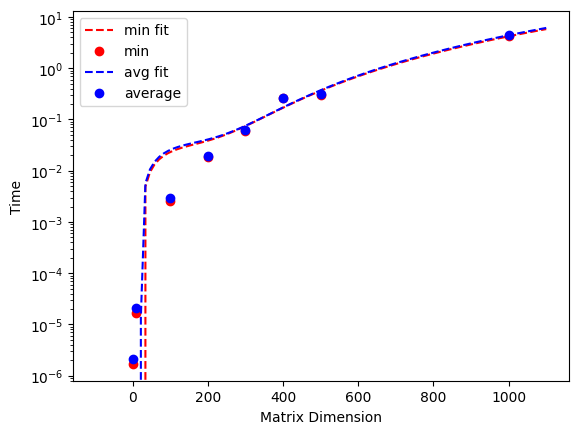

In [14]:
def poly3(x, p0, p1, p2, p3):
    return p0+p1*x+p2*x**2+p3*x**3
    
[p00, p10, p20, p30], _ = sp.optimize.curve_fit(poly3, dims,ts[:,0])
[p01, p11, p21, p31], _ = sp.optimize.curve_fit(poly3, dims,ts[:,1])

canv = np.linspace(dims[0]-(dims[-1]-dims[0])/10,dims[-1]+(dims[-1]-dims[0])/10,100)

print(f'min fit: {p00:.2e}+({p10:.2e})x+({p20:.2e})x^2+({p30:.2e})x^3')
print(f'|p2/p3|= {abs(p20/p30)}')
plt.plot(canv,[poly3(x, p00, p10, p20, p30) for x in canv],'r--',label='min fit')
plt.plot(dims,ts[:,0],'ro',label='min')

print(f'avg fit: {p01:.2e}+({p11:.2e})x+({p21:.2e})x^2+({p31:.2e})x^3')
print(f'|p2/p3|= {abs(p21/p31)}')
plt.plot(canv,[poly3(x, p01, p11, p21, p31) for x in canv],'b--',label='avg fit')
plt.plot(dims,ts[:,1],'bo',label='average')

plt.gca().set_yscale('log')
plt.ylabel('Time')
plt.xlabel('Matrix Dimension')
plt.legend()
plt.show()

Так, мы осуществили полиномиальную аппроксимацию зависимости времени умножения квадратных матриц от их размера кубическим полиномом. Выбор 3 степени как максимальной обусловлен сложностью прямого перемножения $O(n^3)$. Можно заметить, что в использованном методе кубическое слагаемое аппроксимации начинает преобладать в больших матрицах с $n>500$). Кроме того, у маленьких матриц разница между средним и минимальным временем расчета гораздо более заметна - можно говорить, что расчет происходит менее стабильно в терминах предсказуемости времяемкости задачи

In [15]:
big = 2000
time = time_m_mult(big, iters=50)
bigt = [np.min(time), np.average(time)]

Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

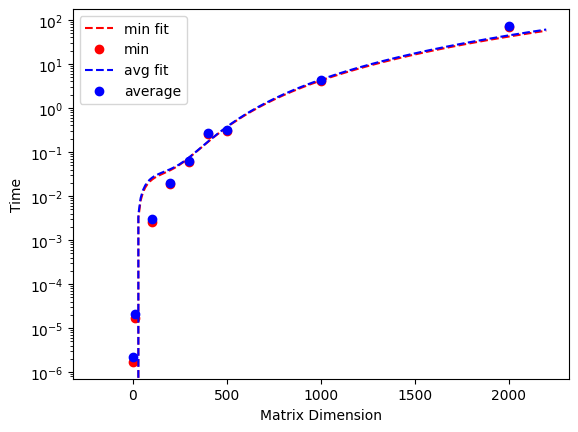

In [16]:
canv = np.linspace(dims[0]-(big-dims[0])/10,big+(big-dims[0])/10,200)

plt.plot(canv,[poly3(x, p00, p10, p20, p30) for x in canv],'r--',label='min fit')
plt.plot(dims,ts[:,0],'ro',label='min')
plt.plot(big,bigt[0],'ro')

plt.plot(canv,[poly3(x, p01, p11, p21, p31) for x in canv],'b--',label='avg fit')
plt.plot(dims,ts[:,1],'bo',label='average')
plt.plot(big,bigt[1],'bo')

plt.gca().set_yscale('log')
plt.ylabel('Time')
plt.xlabel('Matrix Dimension')
plt.legend()
plt.show()

Заметно, что реальное время расчета умножения больших матриц оказалось больше, чем предсканное в результате экстраполяции. Исключим теперь первые точки, которые мы считаем нестабильными и проведем аппроксимацию заново.

In [26]:
[p00, p10, p20, p30], _ = sp.optimize.curve_fit(poly3, dims[3:],ts[3:,0])
[p01, p11, p21, p31], _ = sp.optimize.curve_fit(poly3, dims[3:],ts[3:,1])

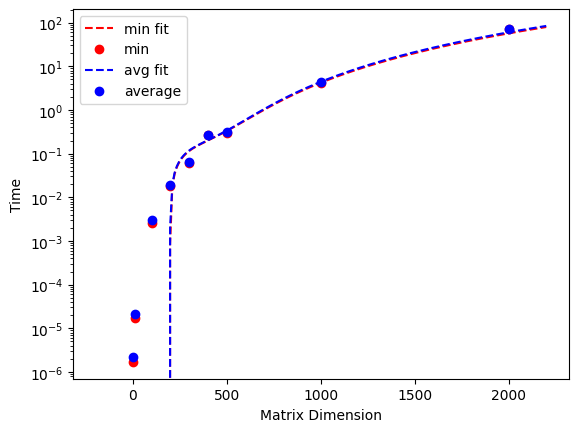

In [27]:
plt.plot(canv,[poly3(x, p00, p10, p20, p30) for x in canv],'r--',label='min fit')
plt.plot(dims,ts[:,0],'ro',label='min')
plt.plot(big,bigt[0],'ro')

plt.plot(canv,[poly3(x, p01, p11, p21, p31) for x in canv],'b--',label='avg fit')
plt.plot(dims,ts[:,1],'bo',label='average')
plt.plot(big,bigt[1],'bo')

plt.gca().set_yscale('log')
plt.ylabel('Time')
plt.xlabel('Matrix Dimension')
plt.legend()
plt.show()

Без первых точек экстраполяция графика происходит с большей точностью к результатам расчета умножения больших матриц

4. В простейшем алгоритме произведения матриц используются три цикла: перебирающие элементы $n$ и $m$  матрицы $C$
и суммирующие по $k$. 
Сравните время перемножения матриц в зависимости от порядка циклов.
Оцените объем кэшей разных уровней, проводя эксперименты для матриц разного размера.

Для простейшего алгоритма, тем не менее, будем использовать ускорение numba Just-in-time, иначе матрицы будут умножаться слишком долго...

In [3]:
@nb.njit(nb.void(nb.float64[:,:], nb.float64[:,:], nb.float64[:, :]))
def simple_mult1(a,b,c): # nmk
    for n in range(a.shape[0]):
        for m in range(b.shape[1]):
            for k in range(a.shape[1]):
                c[n][m]+=a[n][k]*b[k][m]

@nb.njit(nb.void(nb.float64[:,:], nb.float64[:,:], nb.float64[:, :]))
def simple_mult2(a,b,c): # nkm
    for n in range(a.shape[0]):
        for k in range(a.shape[1]):
            for m in range(b.shape[1]):
                c[n][m]+=a[n][k]*b[k][m]

@nb.njit(nb.void(nb.float64[:,:], nb.float64[:,:], nb.float64[:, :]))
def simple_mult3(a,b,c): # mnk
    for m in range(b.shape[1]):
        for n in range(a.shape[0]):
            for k in range(a.shape[1]):
                c[n][m]+=a[n][k]*b[k][m]

@nb.njit(nb.void(nb.float64[:,:], nb.float64[:,:], nb.float64[:, :]))
def simple_mult4(a,b,c): # mkn
    for m in range(b.shape[1]):
        for k in range(a.shape[1]):
            for n in range(a.shape[0]):
                c[n][m]+=a[n][k]*b[k][m]

@nb.njit(nb.void(nb.float64[:,:], nb.float64[:,:], nb.float64[:, :]))
def simple_mult5(a,b,c): # knm
    for k in range(a.shape[1]):
        for n in range(a.shape[0]):
            for m in range(b.shape[1]):
                c[n][m]+=a[n][k]*b[k][m]

@nb.njit(nb.void(nb.float64[:,:], nb.float64[:,:], nb.float64[:, :]))
def simple_mult6(a,b,c): # kmn
    for k in range(a.shape[1]):
        for m in range(b.shape[1]):
            for n in range(a.shape[0]):
                c[n][m]+=a[n][k]*b[k][m]

In [ ]:
gc()

dims = [[20,40,60],[100,200,300],[200,400,600],[500,1000,1500],[750,1500,2250],[1000,2000,3000]]
iters = 20
times = np.zeros((len(dims),6))

for i in tqdm(range(len(dims))):
    dim = dims[i]
    a = np.random.rand(dim[0],dim[1])
    b = np.random.rand(dim[1],dim[2])
    times1 = np.zeros(iters)
    times2 = np.zeros(iters)
    times3 = np.zeros(iters)
    times4 = np.zeros(iters)
    times5 = np.zeros(iters)
    times6 = np.zeros(iters)
    for j in tqdm(range(iters), desc='Iterations'):
        
        c=np.zeros((dim[0],dim[2]))
        t0 = timer()
        simple_mult1(a,b,c)
        t = timer()
        times1[j] = t-t0
        
        c=np.zeros((dim[0],dim[2]))
        t0 = timer()
        simple_mult2(a,b,c)
        t = timer()
        times2[j] = t-t0
        
        c=np.zeros((dim[0],dim[2]))
        t0 = timer()
        simple_mult3(a,b,c)
        t = timer()
        times3[j] = t-t0
        
        c=np.zeros((dim[0],dim[2]))
        t0 = timer()
        simple_mult4(a,b,c)
        t = timer()
        times4[j] = t-t0
        
        c=np.zeros((dim[0],dim[2]))
        t0 = timer()
        simple_mult5(a,b,c)
        t = timer()
        times5[j] = t-t0
        
        c=np.zeros((dim[0],dim[2]))
        t0 = timer()
        simple_mult6(a,b,c)
        t = timer()
        times6[j] = t-t0
    times[i,0]=np.average(times1)
    times[i,1]=np.average(times2)
    times[i,2]=np.average(times3)
    times[i,3]=np.average(times4)
    times[i,4]=np.average(times5)
    times[i,5]=np.average(times6)

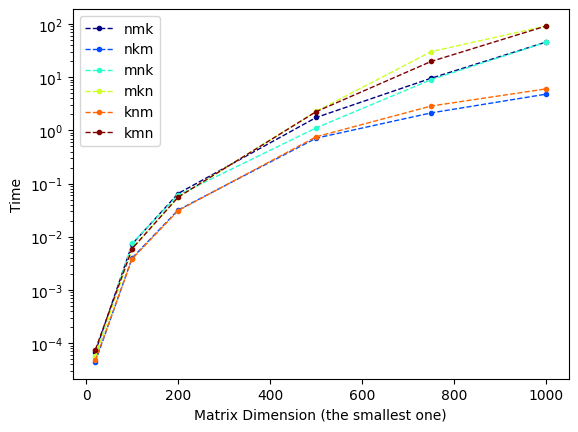

In [14]:
plt.plot([dim[0] for dim in dims],times[:,0],label='nmk')
plt.plot([dim[0] for dim in dims],times[:,1],label='nkm')
plt.plot([dim[0] for dim in dims],times[:,2],label='mnk')
plt.plot([dim[0] for dim in dims],times[:,3],label='mkn')
plt.plot([dim[0] for dim in dims],times[:,4],label='knm')
plt.plot([dim[0] for dim in dims],times[:,5],label='kmn')

plt.gca().set_yscale('log')
plt.ylabel('Time')
plt.xlabel('Matrix Dimension (the smallest one)')
plt.legend()
plt.show()

Можем видеть, что для такого соотношения размеров матриц $(1:2:3)$ явно выделяются три основных порядка суммирования. Тогда допустимо рассматривать только три порядка, например $nmk$, $nkm$ и $kmn$. Создадим достаточно плотную сетку по размерностям матриц и попробуем увидеть замедление, связанное с заполнением быстрых, но маленьких кэшей низкого уровня. При этом будем использовать самый медленный порядок суммирования - $kmn$ - так ожидаем увидеть переполнение кэша раньше

In [21]:
dims0 = [10*i for i in range(80)]
dims = [[x, 2*x, 3*x] for x in dims0]
iters = 10
times1 = np.zeros(len(dims))

gc()

for i in tqdm(range(len(dims))):
    dim = dims[i]
    a = np.random.rand(dim[0],dim[1])
    b = np.random.rand(dim[1],dim[2])
    times_i = np.zeros(iters)
    for j in range(iters):
        
        c=np.zeros((dim[0],dim[2]))
        t0 = timer()
        simple_mult6(a,b,c)
        t = timer()
        times_i[j] = t-t0
        
    times1[i]=np.average(times_i)

  0%|          | 0/80 [00:00<?, ?it/s]

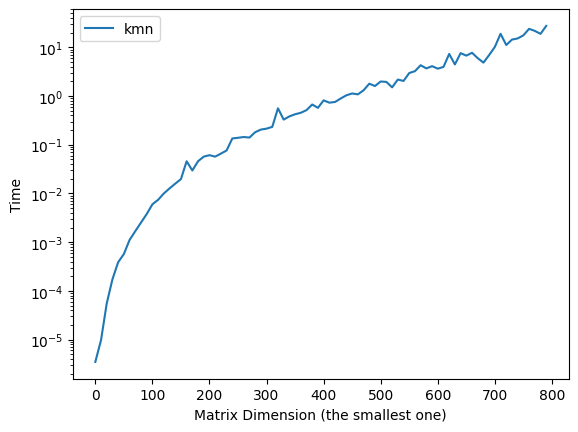

In [22]:
plt.plot([dim[0] for dim in dims],times1[:],label='kmn')

plt.gca().set_yscale('log')
plt.ylabel('Time')
plt.xlabel('Matrix Dimension (the smallest one)')
plt.legend()
plt.show()

Скачков не видно - переполнение кэша не наблюдается. Вероятно, низкие уровни кэша уже чем-то заняты...

5. Обновите функцию для перемножения матриц, используя несколько потоков с помощью numba.prange.
Обновите модель использования вычислительных ресурсов, принимая во внимание число потоков.
Оцените параметры модели из эксперимента.
Какое [параллельное ускорение](https://en.wikipedia.org/wiki/Amdahl%27s_law) вы получили?

In [23]:
@nb.njit(nb.void(nb.float64[:,:], nb.float64[:,:], nb.float64[:, :]), parallel=True)
def paral_mult6(a,b,c): # kmn
    for k in nb.prange(a.shape[1]):
        for m in nb.prange(b.shape[1]):
            for n in nb.prange(a.shape[0]):
                c[n][m]+=a[n][k]*b[k][m]

In [24]:
times2 = np.zeros(len(dims))

gc()

for i in tqdm(range(len(dims))):
    dim = dims[i]
    a = np.random.rand(dim[0],dim[1])
    b = np.random.rand(dim[1],dim[2])
    times_i = np.zeros(iters)
    for j in range(iters):
        
        c=np.zeros((dim[0],dim[2]))
        t0 = timer()
        paral_mult6(a,b,c)
        t = timer()
        times_i[j] = t-t0
        
    times2[i]=np.average(times_i)

  0%|          | 0/80 [00:00<?, ?it/s]

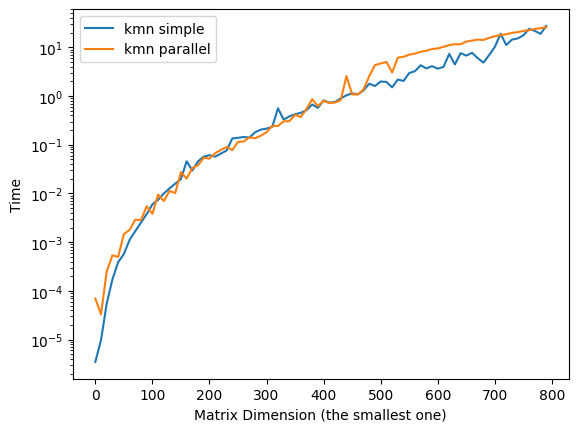

In [25]:
plt.plot([dim[0] for dim in dims],times1[:],label='kmn simple')
plt.plot([dim[0] for dim in dims],times2[:],label='kmn parallel')

plt.gca().set_yscale('log')
plt.ylabel('Time')
plt.xlabel('Matrix Dimension (the smallest one)')
plt.legend()
plt.show()

Видим, что параллелизация не дала ускорения в расчете матриц, значит, для параллелизации был доступен только один поток.

In [9]:
from multiprocessing import cpu_count

print(f'Количество ядер: {cpu_count()}')
print(f'Количество потоков: {nb.config.NUMBA_NUM_THREADS}')

Количество ядер: 4
Количество потоков: 4


Попробуем разобраться, почему параллельное вычисление не дало выигрыш в скорости

In [35]:
nb.set_num_threads(2)
iters = 10
times3 = np.zeros(len(dims))

gc()

for i in tqdm(range(len(dims))):
    dim = dims[i]
    a = np.random.rand(dim[0],dim[1])
    b = np.random.rand(dim[1],dim[2])
    times_i = np.zeros(iters)
    for j in range(iters):
        
        c=np.zeros((dim[0],dim[2]))
        t0 = timer()
        paral_mult6(a,b,c)
        t = timer()
        times_i[j] = t-t0
        
    times3[i]=np.average(times_i)

nb.set_num_threads(4)
iters = 10
times4 = np.zeros(len(dims))

gc()

for i in tqdm(range(len(dims))):
    dim = dims[i]
    a = np.random.rand(dim[0],dim[1])
    b = np.random.rand(dim[1],dim[2])
    times_i = np.zeros(iters)
    for j in range(iters):
        
        c=np.zeros((dim[0],dim[2]))
        t0 = timer()
        paral_mult6(a,b,c)
        t = timer()
        times_i[j] = t-t0
        
    times4[i]=np.average(times_i)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

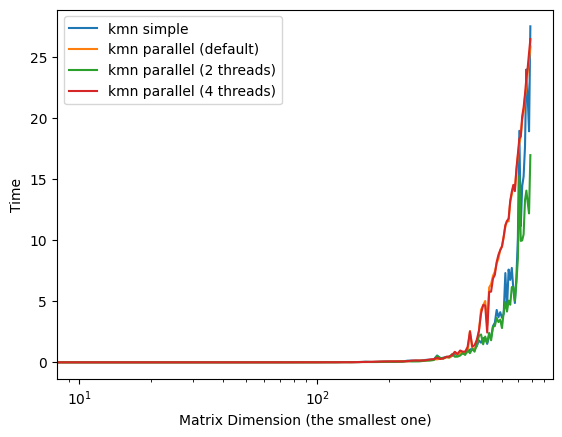

In [36]:
plt.plot([dim[0] for dim in dims],times1[:],label='kmn simple')
plt.plot([dim[0] for dim in dims],times2[:],label='kmn parallel (default)')
plt.plot([dim[0] for dim in dims],times3[:],label='kmn parallel (2 threads)')
plt.plot([dim[0] for dim in dims],times4[:],label='kmn parallel (4 threads)')

plt.gca().set_xscale('log')
plt.ylabel('Time')
plt.xlabel('Matrix Dimension (the smallest one)')
plt.legend()
plt.show()

Странно, но использование 2 или 4 потоков в numba не имеет никакого эффекта на время умножения матриц

6. Сможете ли вы реализовать реализовать на С более быстрый вариант перемножения матриц, чем на numba?

Попробуем максимально ускорить код для умножения матриц. Для этого выберем самый быстрый найденный порядок: $nkm$, используем numba Just-in-Time и prange (параллелизация). Само суммирование напишем через numpy sum - функции numpy работают со скоростью, сравнимой с C, а иногда и быстрее.

In [13]:
@nb.njit(nb.void(nb.float64[:,:], nb.float64[:,:], nb.float64[:, :]), parallel = True, nogil = True, fastmath = True)
def fast_mult(a,b,c): # nkm
    for n in nb.prange(a.shape[0]):
        for m in nb.prange(b.shape[1]):
            c[n][m] = np.sum(a[n,:] * b[:,m])

In [38]:
dims02 = [10*i for i in range(80)]
dims2 = dims#[[x, 2*x, 3*x] for x in dims02]
iters = 10
times5 = np.zeros(len(dims))

gc()

for i in tqdm(range(len(dims02))):
    dim = dims2[i]
    a = np.random.rand(dim[0],dim[1])
    b = np.random.rand(dim[1],dim[2])
    times_i = np.zeros(iters)
    for j in range(iters):
        
        c=np.zeros((dim[0],dim[2]))
        t0 = timer()
        fast_mult(a,b,c)
        t = timer()
        times_i[j] = t-t0
        
    times3[i]=np.average(times_i)

  0%|          | 0/80 [00:00<?, ?it/s]

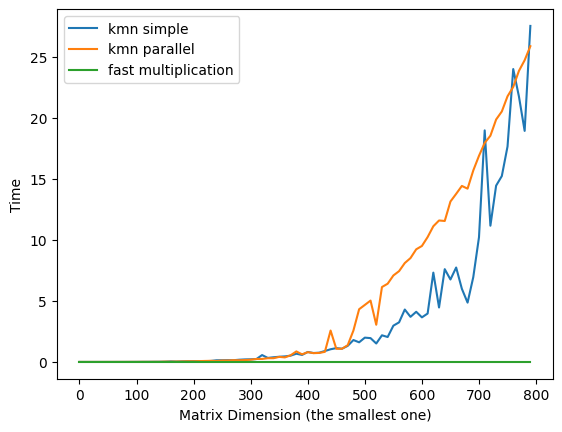

In [39]:
plt.plot([dim[0] for dim in dims],times1[:],label='kmn simple')
plt.plot([dim[0] for dim in dims],times2[:],label='kmn parallel')
plt.plot([dim[0] for dim in dims],times5[:],label='fast multiplication')

#plt.gca().set_yscale('log')
plt.ylabel('Time')
plt.xlabel('Matrix Dimension (the smallest one)')
plt.legend()
plt.show()

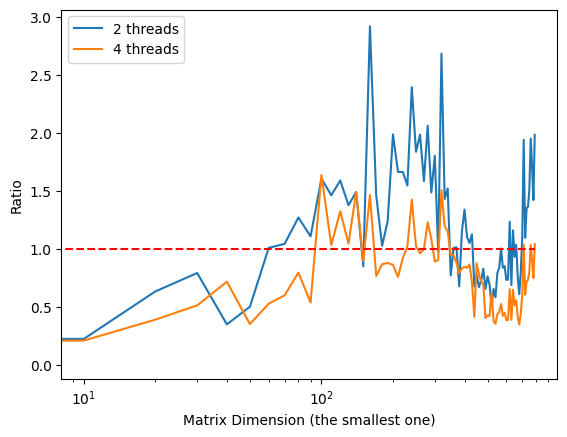

In [40]:
plt.semilogx([dim[0] for dim in dims],[times1[i]/times3[i] for i in range(len(times1))],label='2 threads')
plt.semilogx([dim[0] for dim in dims],[times1[i]/times4[i] for i in range(len(times1))],label='4 threads')
plt.semilogx([dim[0] for dim in dims],[1 for dim in dims],'r--')
plt.ylabel('Ratio')
plt.xlabel('Matrix Dimension (the smallest one)')
plt.legend()
plt.show()

2 потока быстрее, чем 4. Это может иметь смысл в том случае, когда кэш переполнен и деление умножения на много потоков не так выгодно. 

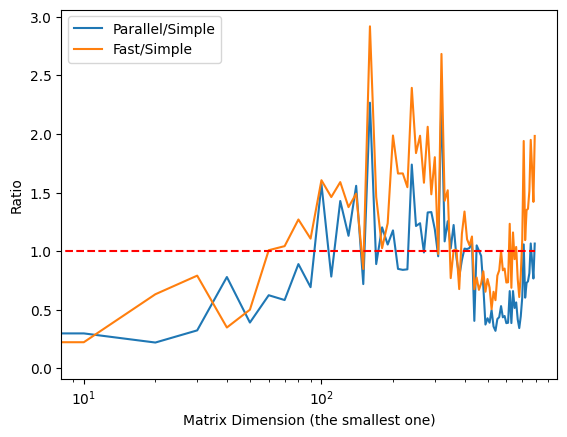

In [41]:
plt.semilogx([dim[0] for dim in dims],[times1[i]/times2[i] for i in range(len(times1))],label='Parallel/Simple')
plt.semilogx([dim[0] for dim in dims],[times1[i]/times3[i] for i in range(len(times1))],label='Fast/Simple')
plt.semilogx([dim[0] for dim in dims],[1 for dim in dims],'r--')
plt.ylabel('Ratio')
plt.xlabel('Matrix Dimension (the smallest one)')
plt.legend()
plt.show()

Наше быстрое умножение не сильно быстрее других рассмотренных алгоритмов, но все же быстрее. Маленьких выигрыш может быть обусловлен неквадратностью матриц и правильным выбором порядка суммирования.

7. Реализуйте быстрое произведение матриц, например, используйте [алгоритм Штрассена](https://en.wikipedia.org/wiki/Strassen_algorithm).
Оцените, на матрицах какого размера быстрое произведение матриц быстрее, чем стандартная реализация.
Какой из методов дает меньшую погрешность вычислений?

Для интереса создадим функцию, которая будет считать по алгоритму Штрассена квадратные матрицы, размерность которых в точности равна степени двойки. В целом, можно было бы считать матрицы любого размера, дополняя нулями их до размерности степени двойки, для этого можно было бы написать простой декоратор функции

In [33]:
@nb.njit(nb.float64[:,:](nb.float64[:,:], nb.float64[:, :]), nogil=True, fastmath=True)
def strassen(a,b):
    c = np.zeros((a.shape[0],a.shape[1]))
    if a.shape[0] > 4:
        d1=a.shape[0]//2
        M1=strassen(a[:d1,:d1]+a[d1:,d1:],b[:d1,:d1]+b[d1:,d1:])
        M2=strassen(a[d1:,:d1]+a[d1:,d1:],b[:d1,:d1])
        M3=strassen(a[:d1,:d1],b[:d1,d1:]-b[d1:,d1:])
        M4=strassen(a[d1:,d1:],b[d1:,:d1]-b[:d1,:d1])
        M5=strassen(a[:d1,:d1]+a[:d1,d1:],b[d1:,d1:])
        M6=strassen(a[d1:,:d1]-a[:d1,:d1],b[:d1,:d1]+b[:d1,d1:])
        M7=strassen(a[:d1,d1:]-a[d1:,d1:],b[d1:,:d1]+b[d1:,d1:])
        c[:d1,:d1] = M1+M4-M5+M7
        c[:d1,d1:] = M3+M5
        c[d1:,:d1] = M2+M4
        c[d1:,d1:] = M1-M2+M3+M6
        #return np.array([[M1+M4-M5+M7, M3+M5],[M2+M4, M1-M2+M3+M6]])
    else:
        c = np.dot(a,b)
    return c

Для быстрого умножения будем использовать два потока, потому что так быстрее.

In [42]:
dims04 = [8,16,32,64,128,256,512,1024]
iters = 10

nb.set_num_threads(2)

times6 = np.zeros(len(dims04))
times7 = np.zeros(len(dims04))

gc()

for i in tqdm(range(len(dims04))):
    dim = dims04[i]
    a = np.random.rand(dim,dim)
    b = np.random.rand(dim,dim)
    times_i = np.zeros((iters,2))
    for j in range(iters):
        c=np.zeros((dim,dim))
        t0 = timer()
        c = strassen(a,b)
        t = timer()
        times_i[j,0] = t-t0
        
        c=np.zeros((dim,dim))
        t0 = timer()
        fast_mult(a,b,c)
        t = timer()
        times_i[j,1] = t-t0
        
    times6[i]=np.average(times_i[:,0])
    times7[i]=np.average(times_i[:,1])

  0%|          | 0/8 [00:00<?, ?it/s]

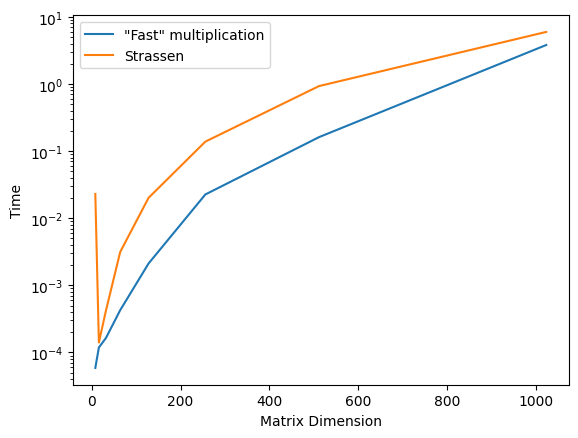

In [44]:
plt.plot(dims04,times7[:],label='"Fast" multiplication')
plt.plot(dims04,times6[:],label='Strassen')

plt.gca().set_yscale('log')
plt.ylabel('Time')
plt.xlabel('Matrix Dimension')
plt.legend()
plt.show()

Алгоритм Штрассена, однако, совсем не быстрее написанного нами быстрого умножения (в предыдущей версии лабы я просто перепутал данные местами)